**Introduction**

Cross Pseudo Supervision (CPS) is a semi-supervised learning technique designed to improve semantic segmentation by leveraging unlabeled data more effectively.

**Concept**



*   CPS uses two neural networks with the same architecture but different
    initializations.
*   Each network generates pseudo labels for the unlabeled data.
*   These pseudo labels are then used to supervise the other network, creating a cross-supervision mechanism.











**Domain Adaptation**

By leveraging labeled source domain data, a small amount of labeled target domain data, and a large amount of unlabeled target domain data, CPS bridges the gap between the source and target domains. This improves the model's performance on the target domain.

**Imports**

In [1]:
%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image

import kagglehub


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Ensure at least 1 GPU is available
print(torch.cuda.current_device())  # Check the active device
print(torch.cuda.get_device_name(0))  # Check the name of your GPU

True
1
0
Tesla T4


**Data Processing**

Source Domain

In [5]:
# Download latest version
source_path = kagglehub.dataset_download("sakshaymahna/cityscapes-depth-and-segmentation")

print("Path to dataset files:", source_path)


Path to dataset files: /kaggle/input/cityscapes-depth-and-segmentation


In [6]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(source_path)

There are 1 directories and 0 images in '/kaggle/input/cityscapes-depth-and-segmentation'.
There are 2 directories and 0 images in '/kaggle/input/cityscapes-depth-and-segmentation/data'.
There are 3 directories and 0 images in '/kaggle/input/cityscapes-depth-and-segmentation/data/val'.
There are 0 directories and 500 images in '/kaggle/input/cityscapes-depth-and-segmentation/data/val/label'.
There are 0 directories and 500 images in '/kaggle/input/cityscapes-depth-and-segmentation/data/val/depth'.
There are 0 directories and 500 images in '/kaggle/input/cityscapes-depth-and-segmentation/data/val/image'.
There are 3 directories and 0 images in '/kaggle/input/cityscapes-depth-and-segmentation/data/train'.
There are 0 directories and 2975 images in '/kaggle/input/cityscapes-depth-and-segmentation/data/train/label'.
There are 0 directories and 2975 images in '/kaggle/input/cityscapes-depth-and-segmentation/data/train/depth'.
There are 0 directories and 2975 images in '/kaggle/input/citysca

In [7]:
# Define directory paths
source_label_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/cityscapes-depth-and-segmentation/versions/1/data/train/label"
source_image_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/cityscapes-depth-and-segmentation/versions/1/data/train/image"

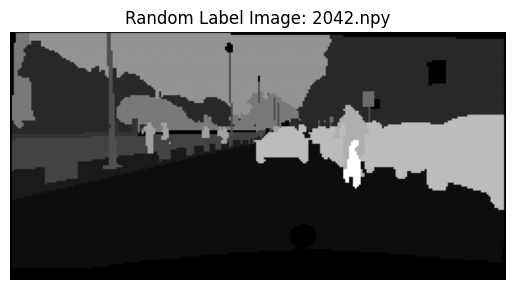

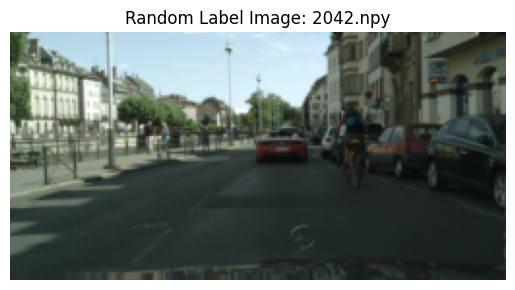

In [8]:
# Select a random label file
random_label = random.choice(os.listdir(source_label_dir))

file_path = os.path.join(source_label_dir, random_label)
image_path = os.path.join(source_image_dir, random_label)


# Load and visualize the data
data = np.load(file_path)
plt.imshow(data, cmap="gray")
plt.title(f"Random Label Image: {random_label}")
plt.axis("off")
plt.show()


# Load and visualize the data
data = np.load(image_path)
plt.imshow(data, cmap="gray")
plt.title(f"Random Label Image: {random_label}")
plt.axis("off")
plt.show()


Target Domain

In [9]:

# Download latest version
target_path = kagglehub.dataset_download("zhangyunsheng/cityscapes-data")

print("Path to dataset files:", target_path)

Path to dataset files: /kaggle/input/cityscapes-data


In [10]:
walk_through_dir(target_path)

There are 2 directories and 0 images in '/kaggle/input/cityscapes-data'.
There are 0 directories and 500 images in '/kaggle/input/cityscapes-data/val'.
There are 0 directories and 2975 images in '/kaggle/input/cityscapes-data/train'.


In [11]:
target_train_dir = '/root/.cache/kagglehub/datasets/zhangyunsheng/cityscapes-data/versions/1/train'
target_val_dir = '/root/.cache/kagglehub/datasets/zhangyunsheng/cityscapes-data/versions/1/val'

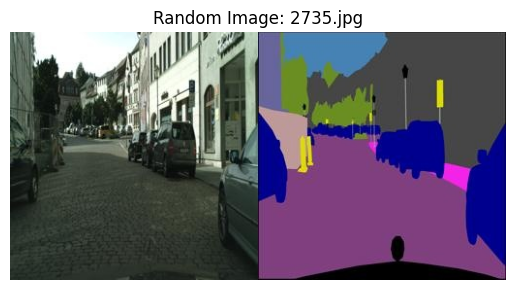

In [12]:
# Get all image filenames
image_files = [f for f in os.listdir(target_train_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.npy'))]

# Select a random image
random_image = random.choice(image_files)

# Construct the full file path
image_path = os.path.join(target_train_dir, random_image)

# Load and visualize the image
if random_image.endswith(".npy"):
    import numpy as np
    data = np.load(image_path)
    plt.imshow(data, cmap="gray")  # Assuming it is grayscale or label mask
else:
    image = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB for correct display
    plt.imshow(image)

plt.title(f"Random Image: {random_image}")
plt.axis("off")
plt.show()


Split Images


In [13]:
image_output_dir = "/root/cityscapes_split/images"
mask_output_dir = "/root/cityscapes_split/masks"

# Create output directories if they don't exist
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(mask_output_dir, exist_ok=True)

# Loop through all files in the source directory
for filename in os.listdir(target_train_dir):
    if filename.endswith((".png", ".jpg", ".jpeg")):  # Only process images
        file_path = os.path.join(target_train_dir, filename)

        # Load the full image
        full_image = cv2.imread(file_path)  # Loads in BGR format

        # Get dimensions
        height, width, _ = full_image.shape

        # Split into left (original image) and right (mask)
        image = full_image[:, :width//2]   # Left half
        mask = full_image[:, width//2:]   # Right half

        # Save the split images
        cv2.imwrite(os.path.join(image_output_dir, filename), image)
        cv2.imwrite(os.path.join(mask_output_dir, filename), mask)

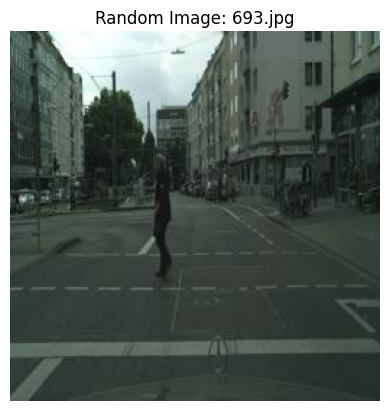

In [14]:
random_image = random.choice(os.listdir(image_output_dir))

# Construct the full file path
image_path = os.path.join(image_output_dir, random_image)

# Load and visualize the image
if random_image.endswith(".npy"):
    import numpy as np
    data = np.load(image_path)
    plt.imshow(data, cmap="gray")  # Assuming it is grayscale or label mask
else:
    image = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB for correct display
    plt.imshow(image)


plt.title(f"Random Image: {random_image}")
plt.axis("off")
plt.show()

Datasets

In [15]:
def dynamic_normalize(tensor):
    print(tensor.shape)
    if tensor.shape[0] == 1:  # Grayscale image
        return tensor.sub_(0.5).div_(0.5)  # Normalize single channel
    else:  # RGB image
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor.sub_(mean).div_(std)  # Normalize three channels

# Example usage
# For advanced augmentations, use Albumentations library
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  # Resize to (256, 256)
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Lambda(dynamic_normalize)  # Normalize for pretrained models
])


In [16]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, labeled_percentage=1.0, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.labeled_percentage = labeled_percentage
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir)) if mask_dir else None
        self.num_labeled = int(len(self.images) * labeled_percentage) if self.masks else 0

        if self.masks and len(self.images) != len(self.masks):
            raise ValueError("Number of images and masks should be the same.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = self.load_image(img_path)

        # Apply transform to image if provided
        if self.transform and isinstance(image, Image.Image):  # Transform PIL images
            image = self.transform(image)

        # Handle mask loading
        mask = self.load_mask(idx, image.shape) if self.mask_dir and idx < self.num_labeled else self.create_empty_mask(image.shape)

        # Resize images and masks
        image = F.interpolate(image.unsqueeze(0), size=(256, 256), mode='bilinear').squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=(256, 256), mode='nearest').long().squeeze(0)

        return image, mask

    def load_image(self, img_path):
        """Load image as a tensor and handle various channel configurations."""
        if img_path.endswith(".npy"):
            data = np.load(img_path).astype(np.float32)
            image = torch.tensor(data).permute(2, 0, 1)  # Convert (H, W, C) → (C, H, W)
        else:
            image = Image.open(img_path).convert("RGB")  # Default to RGB for other image formats
            image = transforms.ToTensor()(image)  # Convert PIL to tensor

        # Dynamically handle the channel count
        if image.shape[0] == 9:  # Handle 9-channel input
            print("Multi-band image detected! Reducing channels to first 3.")
            image = image[:3, :, :]  # Select first 3 channels (pseudo-RGB)
        elif image.shape[0] == 1:  # Handle grayscale
            print("Grayscale image detected! Converting to pseudo-RGB.")
            image = image.repeat(3, 1, 1)  # Convert to pseudo-RGB

        return image

    def load_mask(self, idx, image_shape):
        """Load mask as a tensor and ensure proper shape."""
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        if mask_path.endswith(".npy"):
            data = np.load(mask_path).astype(np.int64)  # Ensure integer labels
            mask = torch.tensor(data).unsqueeze(0)  # Convert (H, W) → (1, H, W)
        else:
            mask = Image.open(mask_path).convert("L")  # Load as grayscale
            mask = transforms.ToTensor()(mask).long()  # Convert to tensor with integer labels

        # Ensure mask has 1 channel
        if mask.shape[0] != 1:
            mask = mask.unsqueeze(0)
        return mask

    def create_empty_mask(self, image_shape):
        """Create an empty mask for unlabeled images."""
        return torch.zeros((1, image_shape[1], image_shape[2]))  # Single-channel, zeros




In [17]:
source_domain = CustomSegmentationDataset(source_image_dir, source_label_dir, transform=transform)
target_domain = CustomSegmentationDataset(image_output_dir, mask_output_dir, labeled_percentage=0.2, transform=transform)

source_dataloader = DataLoader(source_domain, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_domain, batch_size=32, shuffle=True)

In [18]:
def test_dataloader(dataloader):
  batch = next(iter(dataloader))
  images, masks = batch
  print(f"Images shape: {images.shape}")
  print(f"Masks shape: {masks.shape}")

In [19]:
test_dataloader(source_dataloader),

Images shape: torch.Size([32, 3, 256, 256])
Masks shape: torch.Size([32, 1, 256, 256])


(None,)

In [20]:
test_dataloader(target_dataloader)

Images shape: torch.Size([32, 3, 256, 256])
Masks shape: torch.Size([32, 1, 256, 256])


**Models**

In [21]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Normalize feature maps
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)  # Downsample spatial size
        self.fc = nn.Conv2d(64, num_classes, kernel_size=1)  # Pixel-wise classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # Downsamples (H, W) → (H/2, W/2)
        return self.fc(x)  # Outputs per-pixel logits


In [22]:
netA = SimpleNet(19)
netB = SimpleNet(19)

**Pseudo Labeling**

For the unlabeled target domain data, each network generates pseudo labels based on its predictions. These pseudo labels act as a form of supervision for the other network. The pseudo labels from Network A are used to supervise Network B, and vice versa. This cross-supervision mechanism helps the networks learn from each other's strengths and correct potential biases in their predictions.

In [23]:
def generate_pseudo_labels(model, images):
  with torch.no_grad():
    outputs = model(images)
    psuedo_labels = torch.argmax(outputs, dim=1)
  return psuedo_labels

**Train Loop**

In [24]:
optimizerA = torch.optim.Adam(netA.parameters(), lr=0.001)
optimizerB = torch.optim.Adam(netB.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [25]:
def cross_training(modelA, modelB, source_dataloader, target_dataloader, criterion, optimizerA, optimizerB, num_epochs):
    for epoch in range(num_epochs):

        modelA.train()
        modelB.train()

        modelA = modelA.to(device)
        modelB = modelB.to(device)

        total_loss_A, total_loss_B = 0, 0

        # 🔹 Supervised Training on Source Domain
        for images, masks in source_dataloader:
            masks = torch.clamp(masks, min=0)  # Removes negative
            masks = masks.squeeze(1)

            # print("Unique mask values:", torch.unique(masks))
            # print("Mask dtype:", masks.dtype)  # Should be `torch.int64`
            # print("Mask shape:", masks.shape)

            images, masks = images.to(device), masks.to(device)

            predA = modelA(images)
            predB = modelB(images)

            #  Resize masks instead of predictions
            masks_resized = F.interpolate(masks.unsqueeze(1).float(), size=(128, 128), mode="nearest").squeeze(1).long()

            # Standard supervised loss
            loss_A = criterion(predA, masks_resized)
            loss_B = criterion(predB, masks_resized)

            optimizerA.zero_grad()
            loss_A.backward()
            optimizerA.step()

            optimizerB.zero_grad()
            loss_B.backward()
            optimizerB.step()

            total_loss_A += loss_A.item()
            total_loss_B += loss_B.item()

        # Semi-Supervised Training on Target Domain
        for images, _ in target_dataloader:  # Masks are missing (semi-labeled)
            images = images.to(device)

            # Generate pseudo-labels
            pseudo_labels_A = generate_pseudo_labels(modelA, images).detach()
            pseudo_labels_B = generate_pseudo_labels(modelB, images).detach()

            # Resize pseudo-labels to match predictions
            pseudo_labels_A_resized = F.interpolate(pseudo_labels_A.unsqueeze(1).float(), size=(128, 128), mode="nearest").squeeze(1).long()
            pseudo_labels_B_resized = F.interpolate(pseudo_labels_B.unsqueeze(1).float(), size=(128, 128), mode="nearest").squeeze(1).long()

            # Compute CPS losses
            loss_A = criterion(modelA(images), pseudo_labels_B_resized)  # Model A learns from pseudo-labels of B
            loss_B = criterion(modelB(images), pseudo_labels_A_resized)  # Model B learns from pseudo-labels of A

            optimizerA.zero_grad()
            loss_A.backward()
            optimizerA.step()

            optimizerB.zero_grad()
            loss_B.backward()
            optimizerB.step()

            total_loss_A += loss_A.item()
            total_loss_B += loss_B.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss A: {total_loss_A:.4f}, Loss B: {total_loss_B:.4f}")
    return modelA, modelB


In [26]:
modelA, modelB = cross_training(netA, netB, source_dataloader, target_dataloader, criterion,  optimizerA, optimizerB, 20)

Epoch [1/20] - Loss A: 229.9534, Loss B: 235.3718
Epoch [2/20] - Loss A: 211.4938, Loss B: 206.8168
Epoch [3/20] - Loss A: 196.0243, Loss B: 194.6447
Epoch [4/20] - Loss A: 182.3738, Loss B: 181.0997
Epoch [5/20] - Loss A: 170.3651, Loss B: 168.2347
Epoch [6/20] - Loss A: 172.6354, Loss B: 170.5794
Epoch [7/20] - Loss A: 157.9848, Loss B: 158.4492
Epoch [8/20] - Loss A: 167.6034, Loss B: 167.4896
Epoch [9/20] - Loss A: 154.2583, Loss B: 154.7049
Epoch [10/20] - Loss A: 150.5378, Loss B: 150.3225
Epoch [11/20] - Loss A: 152.4573, Loss B: 151.1420
Epoch [12/20] - Loss A: 146.9486, Loss B: 145.5820
Epoch [13/20] - Loss A: 145.8599, Loss B: 145.8599
Epoch [14/20] - Loss A: 145.6771, Loss B: 144.6597
Epoch [15/20] - Loss A: 151.9466, Loss B: 149.2752
Epoch [16/20] - Loss A: 147.9692, Loss B: 145.4555
Epoch [17/20] - Loss A: 145.1930, Loss B: 143.1651
Epoch [18/20] - Loss A: 142.5920, Loss B: 141.8476
Epoch [19/20] - Loss A: 143.3667, Loss B: 142.0074
Epoch [20/20] - Loss A: 143.3041, Loss B

Evaluating of unseen target data

In [33]:
target_val_dir


'/root/.cache/kagglehub/datasets/zhangyunsheng/cityscapes-data/versions/1/val'

In [34]:
test_image_output_dir = "/root/test/cityscapes_split/images"
test_mask_output_dir = "/root/test/cityscapes_split/masks"

# Create output directories if they don't exist
os.makedirs(test_image_output_dir, exist_ok=True)
os.makedirs(test_mask_output_dir, exist_ok=True)

# Loop through all files in the source directory
for filename in os.listdir(target_val_dir):
    if filename.endswith((".png", ".jpg", ".jpeg")):  # Only process images
        file_path = os.path.join(target_val_dir, filename)

        # Load the full image
        full_image = cv2.imread(file_path)  # Loads in BGR format

        # Get dimensions
        height, width, _ = full_image.shape

        # Split into left (original image) and right (mask)
        image = full_image[:, :width//2]   # Left half
        mask = full_image[:, width//2:]   # Right half

        # Save the split images
        cv2.imwrite(os.path.join(test_image_output_dir, filename), image)
        cv2.imwrite(os.path.join(test_mask_output_dir, filename), mask)

In [35]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB
])

test_target_dataset = CustomSegmentationDataset(test_image_output_dir, mask_dir=None, labeled_percentage=0.0,
                                                transform=test_transform)
test_target_dataloader = DataLoader(test_target_dataset, batch_size=32, shuffle=False)

In [36]:
modelA.eval()
modelB.eval()

SimpleNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Conv2d(64, 19, kernel_size=(1, 1), stride=(1, 1))
)

**Qualitative Evaluation: Visual Inspection**

You can visualize the model's predictions to assess segmentation quality by overlaying the predictions on the original images. This is especially useful when ground truth data isn’t available.

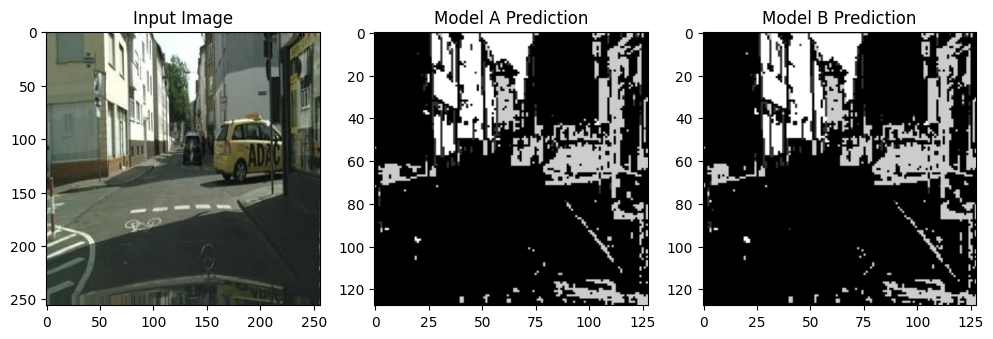

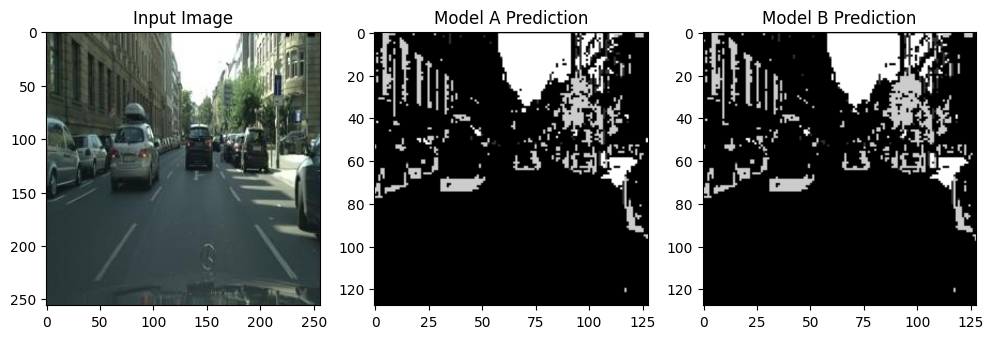

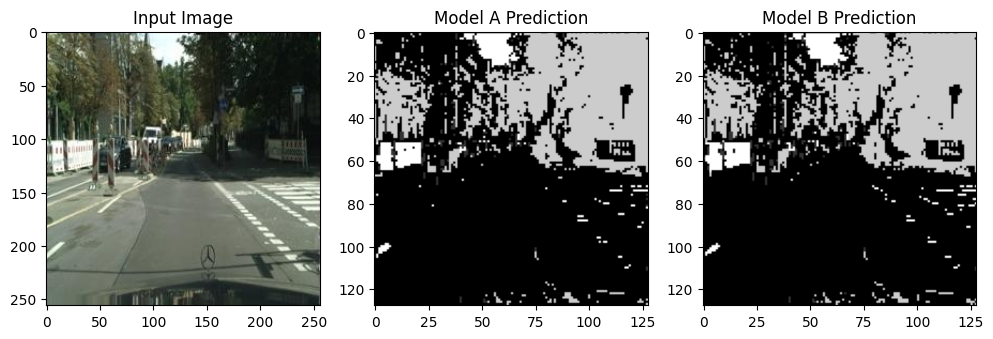

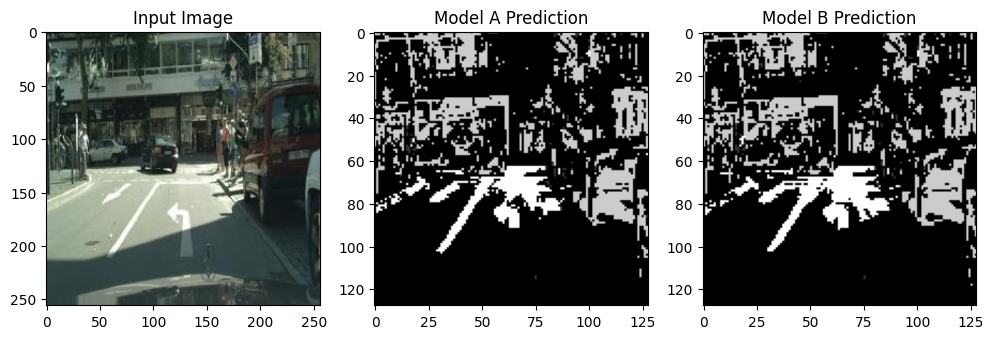

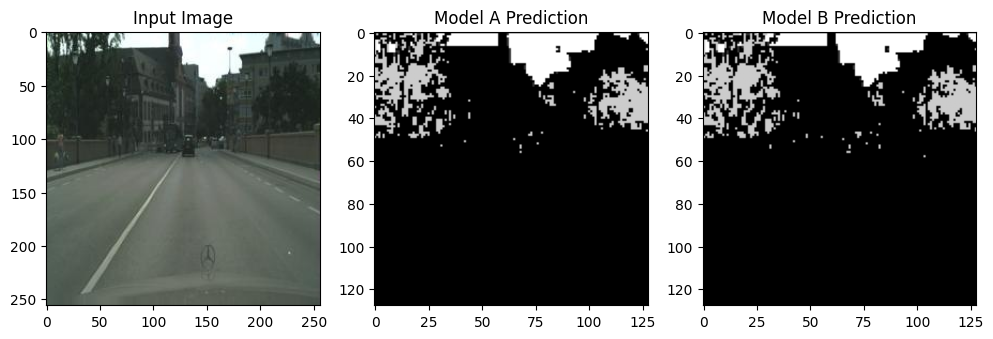

In [37]:
# Loop through a few samples from the target test data
for i, (image, _) in enumerate(test_target_dataloader):
    image = image.to(device)
    with torch.no_grad():
        predsA = torch.argmax(modelA(image), dim=1)  # Model A's predictions
        predsB = torch.argmax(modelB(image), dim=1)  # Model B's predictions

    # Visualize the input image and predictions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy (H, W, C)

    plt.subplot(1, 3, 2)
    plt.title("Model A Prediction")
    plt.imshow(predsA[0].cpu().numpy(), cmap="gray")  # Show prediction as grayscale

    plt.subplot(1, 3, 3)
    plt.title("Model B Prediction")
    plt.imshow(predsB[0].cpu().numpy(), cmap="gray")  # Show prediction as grayscale

    plt.show()

    # Break after a few samples for quick inspection
    if i == 4:
        break

**Confidence-Based Evaluation**

Without ground truth, you can assess the confidence of your model's predictions